### Portfolio of Oil Exploration Assets: Learning Options, Sequential Drilling Options and Defer Options 
####  Marco Antonio Guimarães Dias, 
#### Luigi de Magalhães Detomi Calvette
##### RO Congress - Boston 2017


[Paper](http://www.realoptions.org/openconf2017/data/papers/57.pdf)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [54]:
##Exemplo 1##
r=np.log(1+0.04)
delta=np.log(1+0.05)
sigma=0.2
delta_t=1
T=1
Po=50
div=delta

In [55]:
u=np.exp(sigma*np.sqrt(delta_t))
d=1/u
q= ((np.exp((r-delta)*delta_t) -d))/(u-d)
rho=0.65
print(u)
print(q)

1.2214027581601699
0.4265144714074531


In [56]:
P_m=[]
P_m_1=[]
P_m.append(Po)
for passo in np.arange(T*(1/delta_t)):
    P_m_1.append(P_m[0]*u)
    for i in range(len(P_m)):
        Pd=P_m[i]*d
        P_m_1.append(Pd)
    P_m=[]
    P_m=P_m_1 #Registro Final está em P_m . 
    P_m_1=[]
    #print(P_m)

In [57]:
#Importar Case 1
case_1=pd.read_csv("Case_1.csv", sep=';')
case_1.set_index('Type', inplace=True)
case_1=case_1.astype(float).T


In [58]:
safe=[*case_1.Safe]
risky=[*case_1.Risky]
del safe[2]
del risky[2]

In [59]:
def EMV_portfolio_P(CF_1, I_w_1, q_1, B_1, I_d_1, CF_2, I_w_2, q_2, B_2, I_d_2,P,rho):
#Função criada igual a outra acima, contudo com um só preço. Será usada no cálculo da opção de espera    
    #Métricas da primeiro prospecto
    V_1=q_1*B_1*P;
    I_d_1= I_d_1*(P/50) #com preço base
    NPV_1= V_1- I_d_1
    EMV_1= -I_w_1 + CF_1*NPV_1
    
    
    #Ajuste do Fator de chance do segundo prospecto
    CF_s_2 = CF_2 + (np.sqrt((1-CF_1)/CF_1))*(np.sqrt(CF_2*(1-CF_2)))*rho
    CF_ins_2 = CF_2 - (np.sqrt(CF_1/(1-CF_1)))*(np.sqrt(CF_2*(1-CF_2)))*rho
    
    #Métricas para o segundo prospecto, considerando dois cenários do primeiro poço em Valor Esperado
    V_2=q_2*B_2*P;
    I_d_2= I_d_2*(P/50) #com preço base
    NPV_2= V_2- I_d_2
    
    EMV_s_2= -I_w_2 + CF_s_2*NPV_2
    EMV_ins_2= -I_w_2 + CF_ins_2*NPV_2
    
    #Análise de Portfolio, considerando a informação obtida no primeiro poço
        
    portfolio= EMV_1 + CF_1*max(EMV_s_2,0)+ (1-CF_1)*max(EMV_ins_2,0)
    
    return [max(0,portfolio)]  #qualquer portfolio não aceitará valor negativo de VME



In [60]:
#decisão e Melhor escolha no vencimento
port=[]
decision=[]
for i in range(len(P_m)):
    #lista com a melhor escolha entre SR,RS e abandono=0
    #lista com tamanho de P_m
    W=max(*EMV_portfolio_P(*safe, *risky,P_m[i],rho),*EMV_portfolio_P(*risky,*safe,P_m[i],rho),0)
    port.append(W)
    
    if W <= 0:
        decision.append('AB')
    elif W== EMV_portfolio_P(*safe, *risky,P_m[i],rho):
        decision.append('SR')
    else:
        decision.append('RS')
#print(port)
#print(decision)
    

In [61]:
for passo in np.arange(T*(1/delta_t)):
    P_m_1=[]
    port_1=[]
    decision_1=[]
    
    for i in range(int(len(P_m) -1)):
        P_m_1.append(P_m[i]/u)
        W=[]
        W=max (*EMV_portfolio_P(*safe, *risky,P_m_1[i],rho),
               *EMV_portfolio_P(*risky,*safe,P_m_1[i],rho), 
               np.exp(-r*delta_t)*(q*port[i]+(1-q)*port[i+1]), 0)
        port_1.append(W)
        #port_1 terá o valor da opção hoje
        #port tera o valor do portfolio no vencimento
        if W <= 0:
            decision_1.append('AB')
        elif W== EMV_portfolio_P(*safe, *risky,P_m_1[i],rho):
            decision_1.append('SR')
        elif W== EMV_portfolio_P(*risky, *safe,P_m_1[i],rho):
            decision_1.append('RS')
        else:
            decision_1.append('WS')
    #print(P_m_1)
    decision=decision_1
    port=port_1
    P_m=P_m_1
    
print(P_m)    
print(decision_1)
print(port_1)    
#print(port)

[50.0]
['WS']
[13.142504417551404]


In [62]:
def defer_seq(case,r,delta,sigma,delta_t,T,Po,rho):
    # Defer Option
    #def defer_seq_learning_option(r,Po,delta,sigma,delta_t,T):
    # Método binomial Cox-Ross-Rubinstein - Baseado nos exercícios do Marco Antonio 
    #e Capítilo 9 do primeiro livro
    #Usando dois somente dois vetores para propagar, não uma matriz7
    #usando recombinação
    
    ##############################
    #up, down e medida neutra ao risco
    u=np.exp(sigma*np.sqrt(delta_t))
    d=1/u
    q= ((np.exp((r-delta)*delta_t) -d))/(u-d)

    ###################################
    #Propagação da variável estocástica
    P_m=[]
    P_m_1=[]
    P_m.append(Po)
    for passo in np.arange(T*(1/delta_t)):
        P_m_1.append(P_m[0]*u)
        for i in range(len(P_m)):
            Pd=P_m[i]*d
            P_m_1.append(Pd)
        P_m=[]
        P_m=P_m_1 #Registro Final está em P_m . 
        P_m_1=[]
    
    safe=[*case.Safe]
    risky=[*case.Risky]
    del safe[2]
    del risky[2]


    #######################################
    #decisão e Melhor escolha no vencimento
    port=[] 
    decision=[]
    for i in range(len(P_m)):
        #lista com a melhor escolha entre SR,RS e abandono=0
        #lista com tamanho de P_m
        W=max(*EMV_portfolio_P(*safe, *risky,P_m[i],rho),*EMV_portfolio_P(*risky,*safe,P_m[i],rho),0)
        port.append(W)
        if W <= 0:
            decision.append('AB')
        elif W== EMV_portfolio_P(*safe, *risky,P_m[i],rho):
            decision.append('SR')
        else:
            decision.append('RS')

    ############################
    #Deporpagação até o presente       

    for passo in np.arange(T*(1/delta_t)):
        P_m_1=[]
        port_1=[]
        decision_1=[]
        
        for i in range(int(len(P_m) -1)):
            P_m_1.append(P_m[i]/u)
            W=[]
            W=max (*EMV_portfolio_P(*safe, *risky,P_m_1[i],rho),
                   *EMV_portfolio_P(*risky,*safe,P_m_1[i],rho), 
                   np.exp(-r*delta_t)*(q*port[i]+(1-q)*port[i+1]), 0)
            port_1.append(W)
            #port_1 terá o valor da opção hoje
            #port tera o valor do portfolio no vencimento
            
            if W <= 0:
                decision_1.append('AB')
            elif W== EMV_portfolio_P(*safe, *risky,P_m_1[i],rho):
                decision_1.append('SR')
            elif W== EMV_portfolio_P(*risky, *safe,P_m_1[i],rho):
                decision_1.append('RS')
            else:
                decision_1.append('WS')
        decision=decision_1
        port=port_1
        P_m=P_m_1
    
    return[*decision_1,
           *port_1,
           *EMV_portfolio_P(*safe, *risky,P_m_1[i],rho),
           *EMV_portfolio_P(*risky,*safe,P_m_1[i],rho)]
    
    

In [419]:
###Exemplo 2###
r=np.log(1+0.04)
#print(r)
delta=np.log(1+0.05)
sigma=0.2
delta_t=1/3
T=3
Po=50
rho=0.65


In [66]:
#Importar Case 2
case_2=pd.read_csv("Case_2.csv", sep=';')
case_2.set_index('Type', inplace=True)
case_2=case_2.astype(float).T
case_2.head(6)


Type,Safe,Risky
CF,0.5,0.30
I_w,70.0,45.00
P,50.0,50.00
q,0.1,0.12
B,600.0,500.00
I_d,2900.0,2800.00


In [67]:
#Há um erro no paper. Para o exemplo 1, o valor é 18.95. No paper está 20.46
defer_seq(case_1,r,delta,sigma,delta_t,T,Po,0.75)

['WS', 18.95974533771078, 14.495454169735044, 15.49545416973504]

In [72]:
###Exemplo 2###
r=np.log(1+0.04)
#print(r)
delta=np.log(1+0.05)
sigma=0.2
delta_t=1/(6*24)
T=3
Po=50
rho=0.65


In [73]:

defer_seq(case_2,r,delta,sigma,delta_t,T,Po,rho)

['WS', 24.479323227723437, 17.28674201721296, 23.893371008606483]

In [424]:
##Loop para gerar o gráfico do gatilho###
Price=[]
Time=[]
Dec=[]
for T in np.arange(0.01,3.1,0.25):
    Check=defer_seq(case_2,r,delta,sigma,delta_t,(3.1- T),30,rho)[0]
    for Po in np.arange(30,75.1,0.1):
        if defer_seq(case_2,r,delta,sigma,delta_t,(3.1- T),Po,rho)[0] != Check:
            Price.append(Po)
            Time.append(T)
            Check=defer_seq(case_2,r,delta,sigma,delta_t,(3.1-T),Po,rho)[0]
            Dec.append(Check)
            
df=pd.DataFrame(Price)
df.columns=['Price']
df['Time']=Time
df['Decision']=Dec

In [425]:
WS=df[df.Decision == 'WS']
RS=df[df.Decision == 'RS']
SR=df[df.Decision == 'SR']

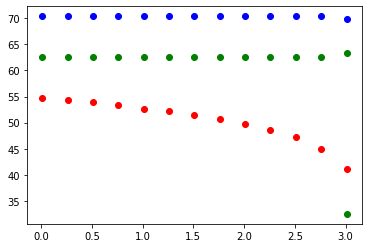

In [426]:

plt.plot(SR.Time, SR.Price, 'bo', color='b' )
plt.plot(RS.Time, RS.Price, 'bo', color='r')
plt.plot(WS.Time, WS.Price, 'bo', color='g')

In [19]:
###Exemplo 1###
r=np.log(1+0.04)
#print(r)
delta=np.log(1+0.05)
sigma=0.3
delta_t=1/24
T=3
Po=50
rho=0.65


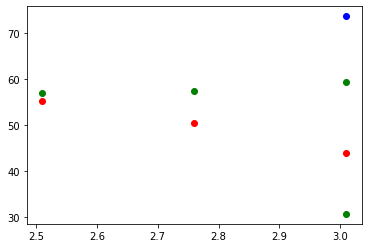

In [20]:
##Loop para gerar o gráfico do gatilho###
Price=[]
Time=[]
Dec=[]
for T in np.arange(0.01,3.1,0.25):
    Check=defer_seq(case_2,r,delta,sigma,delta_t,(3.1- T),30,rho)[0]
    for Po in np.arange(30,75.1,0.1):
        if defer_seq(case_2,r,delta,sigma,delta_t,(3.1- T),Po,rho)[0] != Check:
            Price.append(Po)
            Time.append(T)
            Check=defer_seq(case_2,r,delta,sigma,delta_t,(3.1-T),Po,rho)[0]
            Dec.append(Check)
            
df=pd.DataFrame(Price)
df.columns=['Price']
df['Time']=Time
df['Decision']=Dec

WS=df[df.Decision == 'WS']
RS=df[df.Decision == 'RS']
SR=df[df.Decision == 'SR']

plt.plot(SR.Time, SR.Price, 'bo', color='b' )
plt.plot(RS.Time, RS.Price, 'bo', color='r')
plt.plot(WS.Time, WS.Price, 'bo', color='g')

In [5]:
######################################################
#####################################################
#############Solucao para permutacao automática#####


In [6]:
#############################3333
##########Questões da permutação do portfolio

In [7]:
import itertools

In [125]:
#Importar Case ABC
case_ABC=pd.read_csv("Case_2.csv", sep=';')
case_ABC.set_index('Type', inplace=True)
case_ABC=case_ABC.astype(float).T


In [126]:
case_ABC

Type,Safe,Risky
CF,0.5,0.30
I_w,70.0,45.00
P,50.0,50.00
q,0.1,0.12
B,600.0,500.00
I_d,2900.0,2800.00


In [10]:
seq=[]
n=case_ABC.shape[1]
perm=itertools.permutations(range(n))
for k in list(perm):
    print(k[0], k[1])
    seq.append(k)
    
   

0 1
1 0


In [11]:
seq

[(0, 1), (1, 0)]

In [12]:
n

2

In [123]:
#Importar correlacao Case 2 como ABC
case_ABC_corr=pd.read_csv("Case_2_corr.csv", sep=';')
case_ABC_corr.set_index('Type', inplace=True)


In [124]:
case_ABC_corr

,A,B
Type,,
A,1.00,0.65
B,0.65,1.00


In [15]:
case_ABC_corr.iloc[0,1]

0.65

In [16]:
#####################Original
fold=[]
seq=[]
P=50
n=case_ABC.shape[1]
perm=itertools.permutations(range(n))
for k in list(perm):
    seq.append(k)
    print(k)
    m=np.zeros((2**(n-1),n))
    p=np.zeros((2**(n-1),n))
    pi=np.zeros((2**(n-1),n))
    m[m==0]=np.nan
    p[m==0]=np.nan
    pi[pi==0]=np.nan
    
    
    m[0,0]=case_ABC.iloc[0,k[0]] ### Capta da permutacao, o fc da Primeira na ordem de perfuracao
    p[0,0]=1  #probabilidade de ocorrencia de perfuração do primeiro prospecto
    # portfolio= fc*(P*q*B - P/50*Id) - Iw  - do primeiro prospecto
    pi[0,0]=m[0,0]*(P*case_ABC.iloc[3,k[0]]*case_ABC.iloc[4,k[0]] - (P/50)*case_ABC.iloc[5,k[0]]) -case_ABC.iloc[1,k[0]]
    
    
    
    
    for j in range(n-1):
        print("j é",j)
        for i in range(2**(j)):
            rho=case_ABC_corr.iloc[k[j],k[j+1]]
            cf=case_ABC.iloc[0,k[j+1]]
            #print("i é",i)
            #print('rho',case_ABC_corr.iloc[k[j],k[j+1]], 'cf', case_ABC.iloc[0,k[j+1]] )
            CF_s = cf + np.sqrt((m[i,j] -m[i,j]**2)*(cf-cf**2))*(rho/m[i,j])
            m[2*i,j+1]=CF_s
            p[2*i,j+1]=m[i,j]*p[i,j]
            pi[2*i,j+1]=CF_s*(P*case_ABC.iloc[3,k[j+1]]*case_ABC.iloc[4,k[j+1]] - (P/50)*case_ABC.iloc[5,k[j+1]]) -case_ABC.iloc[1,k[j+1]]
    
            
            CF_ins = cf - np.sqrt((m[i,j] -m[i,j]**2)*(cf-cf**2))*(rho/(1-m[i,j]))
            m[2*i+1,j+1]=CF_ins
            p[2*i+1,j+1]=(1-m[i,j])*p[i,j]
            pi[2*i+1,j+1]=CF_ins*(P*case_ABC.iloc[3,k[j+1]]*case_ABC.iloc[4,k[j+1]] - (P/50)*case_ABC.iloc[5,k[j+1]]) -case_ABC.iloc[1,k[j+1]]
            
    print(m)
            
    
    for l in np.arange(n-2,-1,-1):
        #print(l)
        for g in range(2**(l)):
            #print(pi[g,l],m[g,l], pi[2*g,l+1],(1-m[g,l]), pi[2*g+1,l+1]   )
            pi[g,l]= np.maximum(0,pi[g,l] + m[g,l]*np.maximum(0,pi[2*g,l+1]) + (1-m[g,l])*np.maximum(0,pi[2*g+1,l+1]))
    #print(pi)
    fold.append(pi[0,0])
    

###Fornece o melhor portfolio seq_winner e o valor do porfolio winner
winner=np.amax(fold)
Seq_winner=seq[np.argmax(fold)]
winner=np.maximum(0,winner)
if winner==0:
    Seq_winner=np.nan

    
    
            

    #print(fold)
    #print(m)
print('melhor portfolio é:',Seq_winner, 'e o valor é:', winner, fold)
#print(fold)

(0, 1)
j é 0
[[0.5        0.59786742]
 [       nan 0.00213258]]
(1, 0)
j é 0
[[0.3        0.9964457 ]
 [       nan 0.28723756]]
melhor portfolio é: (1, 0) e o valor é: 23.893371008606483 [17.28674201721296, 23.893371008606483]


In [17]:
####Transformando em função

def carteira(case,case_corr,P):
    fold=[]
    seq=[]
    #P=50
    n=case.shape[1]
    perm=itertools.permutations(range(n))
    
    for k in list(perm):
        seq.append(k)
        #print(k[0], k[1])
        m=np.zeros((2**(n-1),n))
        p=np.zeros((2**(n-1),n))
        pi=np.zeros((2**(n-1),n))
        
        m[m==0]=np.nan
        p[m==0]=np.nan
        pi[pi==0]=np.nan
        
        m[0,0]=case_ABC.iloc[0,k[0]] ### Capta da permutacao, o fc da Primeira na ordem de perfuracao
        p[0,0]=1
        pi[0,0]=m[0,0]*(P*case_ABC.iloc[3,k[0]]*case_ABC.iloc[4,k[0]] - (P/50)*case_ABC.iloc[5,k[0]]) -case_ABC.iloc[1,k[0]]
        
        
        for j in range(n-1):
            #print("j é",j)
            
            for i in range(2**(j)):
                rho=case_corr.iloc[k[j],k[j+1]]
                cf=case_ABC.iloc[0,k[j+1]]
                #print("i é",i)
                #print('rho',case_corr.iloc[k[j],k[j+1]], 'cf', case_ABC.iloc[0,k[j+1]] )
                CF_s = cf + np.sqrt((m[i,j] -m[i,j]**2)*(cf-cf**2))*(rho/m[i,j])
                m[2*i,j+1]=CF_s
                p[2*i,j+1]=m[i,j]*p[i,j]
                
                pi[2*i,j+1]=CF_s*(P*case_ABC.iloc[3,k[j+1]]*case_ABC.iloc[4,k[j+1]] - (P/50)*case_ABC.iloc[5,k[j+1]]) -case_ABC.iloc[1,k[j+1]]
                
                
                CF_ins = cf - np.sqrt((m[i,j] -m[i,j]**2)*(cf-cf**2))*(rho/(1-m[i,j]))
                m[2*i+1,j+1]=CF_ins
                p[2*i+1,j+1]=(1-m[i,j])*p[i,j]
                
                pi[2*i+1,j+1]=CF_ins*(P*case_ABC.iloc[3,k[j+1]]*case_ABC.iloc[4,k[j+1]] - (P/50)*case_ABC.iloc[5,k[j+1]]) -case_ABC.iloc[1,k[j+1]]
                
                #print(m)
                
        for l in np.arange(n-2,-1,-1):
            #print(l)
            for g in range(2**(l)):
                #print(pi[g,l],m[g,l], pi[2*g,l+1],(1-m[g,l]), pi[2*g+1,l+1]   )
                pi[g,l]= np.maximum(0,pi[g,l] + m[g,l]*np.maximum(0,pi[2*g,l+1]) + (1-m[g,l])*np.maximum(0,pi[2*g+1,l+1]))
                #print(pi)
        fold.append(pi[0,0])
    
    ###Fornece o melhor portfolio seq_winner e o valor do porfolio winner
    winner=np.amax(fold)
    Seq_winner=seq[np.argmax(fold)]
    winner=np.maximum(0,winner)
    if winner==0:
        Seq_winner=np.nan
    
    m=[]
    pi=[]
    
    return [Seq_winner, winner, fold]
    #return [fold]
    
            

    

In [18]:
carteira(case_ABC,case_ABC_corr,50)

[(1, 0), 23.893371008606483, [17.28674201721296, 23.893371008606483]]

In [55]:
def diffinexpcart(V,case_ABC,case_ABC_corr,r,div,sigma,tau):
    #############################################################
    #######Método por diferenças finitas explícitas##############
    accur=0.05  #Porcentagem de acurácia
    
    #####Solução por diferenças finita explícitas###
    #Precisão em e intervalo da célula em V
    deltaV=V*accur
    
    # M são as divisões do grid em V
    #forcei a barra- coloque 3 vezes a V de perpetuidade. Estava 1,1 
    #M= int(1.1*vcritico(I,r,div,sigma,tau)[2]/deltaV) # Max é 10% acima do gatilho em perpetuidade. Vcrit- com gati precisa de tau
    M=int(1.5*V)
    VGrid=int(V/deltaV) #Ponto do grid onde esta V_0. 
    #deltat= (deltaV**2)/((sigma**2)*((3*I)**2)) #Convergência: Critério do peso central >=0. Vmax=3I ><1.1Gatilho_perp
    deltat= (deltaV**2)/((sigma**2)*((3*2*V)**2))
    N= int(tau/deltat) +1
    
    df=1/(1+(r*deltat)) # fator de desconto
    
    #Vetor Vt
    Vt=np.zeros(M+1)
    Gatilho=np.zeros(N+1)
    F=np.zeros((N+1,M+1))
    deltat=tau/N
    for i in range(M+1):
        Vt[i]= i*deltaV
        F[N,i]=carteira(case_ABC,case_ABC_corr,Vt[i])[1]
        #F[N,i]=np.maximum(0,Vt[i]-I)
    #Gatilho[N]=I
    
    ##############Loop################
    for j in range(N-1,-1,-1): #de N-1 até zero(-1) pulando em -1
        for i in range(1,M,1): # de 1 até M-1 pulando em 1
            pu= 0.5*((sigma**2)*(i**2) + ((r - div)*i))*deltat
            pm = 1 - (sigma**2)*(i**2)*deltat
            pd = 0.5*((sigma**2)*(i**2) - ((r - div)*i))*deltat
            F[j,i]= df*(pu*F[j+1,i+1] + pm*F[j+1,i] + pd*F[j+1,i - 1])
            
            ###Vetor Gatilho####
            #if F[j,i]< Vt[i]-I and F[j,i-1]>Vt[i-1]-I:
            #    Gatilho[j]=(Vt[i]+Vt[i-1])/2
            
            
            F[j,i]=np.maximum(carteira(case_ABC,case_ABC_corr,Vt[i])[1], F[j,i])  #opção americana
        
        
        F[j,0]=0
        F[j,M]=carteira(case_ABC,case_ABC_corr,Vt[i])[1]
        
        
    T=np.linspace(0,tau,num=len(Gatilho))
    
    ###Retorna A opção hoje, Gatilho, Tempo, Vt, Matrix para Gráficos
    return[F[0,VGrid],Gatilho,T,Vt,F]



In [56]:
diffinexpcart(50,case_ABC,case_ABC_corr,r,div,sigma,tau)[0]

24.47261995966586

In [19]:
tau=3

In [20]:
##Exemplo Parâmetro##
r=np.log(1+0.04)
delta=np.log(1+0.05)
sigma=0.2
T=3
Po=50
div=delta

In [21]:

####Formalização - Caso 1

#Importar Case 1
case_1=pd.read_csv("Case_1.csv", sep=';')
case_1.set_index('Type', inplace=True)
case_1=case_1.astype(float).T

#Importar Case 1 - correlacao
case_1_corr=pd.read_csv("Case_1_corr.csv", sep=';')
case_1_corr.set_index('Type', inplace=True)


diffinexpcart(50,case_1,case_1_corr,r,div,sigma,tau)[0]



NameError: name 'diffinexpcart' is not defined

In [121]:

####Formalização - Caso 2

#Importar Case 2
case_2=pd.read_csv("Case_2.csv", sep=';')
case_2.set_index('Type', inplace=True)
case_2=case_2.astype(float).T

#Importar Case 2 - correlacao
case_2_corr=pd.read_csv("Case_2_corr.csv", sep=';')
case_2_corr.set_index('Type', inplace=True)


diffinexpcart(50,case_2,case_2_corr,r,div,sigma,tau)[0]



In [109]:
####Formalização - Caso 3 

#Importar Case 3
case_ABC=pd.read_csv("Case_ABC.csv", sep=';')
case_ABC.set_index('Type', inplace=True)
case_ABC=case_ABC.astype(float).T



In [110]:
case_ABC

Type,S,I,R
CF,0.3,0.25,0.20
I_w,70.0,60.00,50.00
P,50.0,50.00,50.00
q,0.1,0.11,0.12
B,500.0,600.00,700.00
I_d,2300.0,3100.00,4000.00


In [111]:
#Importar Case 3 - correlacao
case_ABC_corr=pd.read_csv("Case_ABC_corr.csv", sep=';')
case_ABC_corr.set_index('Type', inplace=True)


In [112]:
case_ABC_corr

,S,I,R
Type,,,
S,1.0,0.5,0.5
I,0.5,1.0,0.6
R,0.5,0.6,1.0


In [86]:
carteira(case_ABC,case_ABC_corr,50)

[(0, 1, 2),
 1.141388517656745,
 [1.141388517656745,
  0.6377574259052832,
  1.0518564346183137,
  0.25074182999601646,
  0.4169899785174582,
  0.12170601480081444]]

In [88]:
solucao=diffinexpcart(50,case_ABC,case_ABC_corr,r,div,sigma,tau)

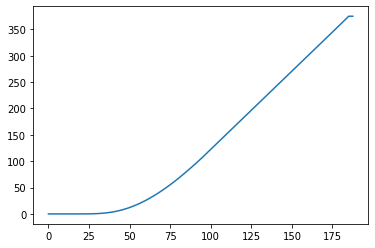

In [98]:
plt.plot(solucao[3],solucao[4][50,:])

In [479]:
import time
start=time.time()
solucao=diffinexpcart(50,case_3,case_3_corr,r,div,sigma,tau)[0]
cpu=  time.time() - start

In [26]:
#################3Formalicacao caso 4
#Importar Case 4
case_ABC=pd.read_csv("Case_ABCD.csv", sep=';')
case_ABC.set_index('Type', inplace=True)
case_ABC=case_ABC.astype(float).T






In [127]:
case_ABC

Type,Safe,Risky
CF,0.5,0.30
I_w,70.0,45.00
P,50.0,50.00
q,0.1,0.12
B,600.0,500.00
I_d,2900.0,2800.00


In [30]:
#Importar Case 4 - correlacao
case_ABC_corr=pd.read_csv("Case_ABCD_corr.csv", sep=';')
case_ABC_corr.set_index('Type', inplace=True)


In [128]:
case_ABC_corr

,A,B
Type,,
A,1.00,0.65
B,0.65,1.00


In [129]:
#################Formalizacao caso 4 - correto
fold=[]
seq=[]
P=50
n=case_ABC.shape[1]
perm=itertools.permutations(range(n))
for k in list(perm):
    seq.append(k)
    #print(k)
    m=np.zeros((2**(n-1),n))
    p=np.zeros((2**(n-1),n))
    pi=np.zeros((2**(n-1),n))
    m[m==0]=np.nan
    p[m==0]=np.nan
    pi[pi==0]=np.nan
    
    
    m[0,0]=case_ABC.iloc[0,k[0]] ### Capta da permutacao, o fc da Primeira na ordem de perfuracao
    pi[0,0]=m[0,0]*(P*case_ABC.iloc[3,k[0]]*case_ABC.iloc[4,k[0]] - (P/50)*case_ABC.iloc[5,k[0]]) -case_ABC.iloc[1,k[0]]
    
    #Vetores Auxiliares
    Ax_m=[]
    Ax1_m=[]
    Ax_pi=[]
    ##Loop para criacao da matriz de FC e VME
    for y in range(1,n,1):
        Ax_m.append(case_ABC.iloc[0,k[y]])
    
    
    for j in range(n-1):
        p=0
        for q in range(1+j,n,1):
            for i in range(2**(j)):
                p=p+1
                #print(p-1,j,q,i,j)
                CF_s=Ax_m[p-1] +case_ABC_corr.iloc[k[j],k[q]]*np.sqrt((m[i,j]-m[i,j]**2)*(Ax_m[p-1]-Ax_m[p-1]**2))/m[i,j]
                Ax1_m.append(CF_s)
                CF_ins=Ax_m[p-1] -case_ABC_corr.iloc[k[j],k[q]]*np.sqrt((m[i,j]-m[i,j]**2)*(Ax_m[p-1]-Ax_m[p-1]**2))/(1-m[i,j])
                Ax1_m.append(CF_ins)
                
                Ax_pi.append(CF_s*(P*case_ABC.iloc[3,k[j+1]]*case_ABC.iloc[4,k[j+1]] - (P/50)*case_ABC.iloc[5,k[j+1]]) -case_ABC.iloc[1,k[j+1]])
                Ax_pi.append(CF_ins*(P*case_ABC.iloc[3,k[j+1]]*case_ABC.iloc[4,k[j+1]] - (P/50)*case_ABC.iloc[5,k[j+1]]) -case_ABC.iloc[1,k[j+1]])
                

        m[0:2*(i+1),j+1]=Ax1_m[0:2*(i+1)]
        pi[0:2*(i+1),j+1]=Ax_pi[0:2*(i+1)]
        
        del Ax1_m[0:2*(i+1)]
        
        Ax_m=Ax1_m
        Ax1_m=[]
        Ax_pi=[]
    
    #print(100*m)
    #print(pi)
    
    for l in np.arange(n-2,-1,-1):
        #print(l)
        for g in range(2**(l)):
            #print(pi[g,l],m[g,l], pi[2*g,l+1],(1-m[g,l]), pi[2*g+1,l+1]   )
            pi[g,l]= np.maximum(0,pi[g,l] + m[g,l]*np.maximum(0,pi[2*g,l+1]) + (1-m[g,l])*np.maximum(0,pi[2*g+1,l+1]))
    #print(pi)
    fold.append(pi[0,0])
    

###Fornece o melhor portfolio seq_winner e o valor do porfolio winner
winner=np.amax(fold)
Seq_winner=seq[np.argmax(fold)]
winner=np.maximum(0,winner)
if winner==0:
    Seq_winner=np.nan

    
    
            

    #print(fold)
    #print(m)
print('melhor portfolio é:',Seq_winner, 'e o valor é:', winner, fold)
#print(fold)
    
    
    
    
    
    

melhor portfolio é: (1, 0) e o valor é: 23.893371008606483 [17.28674201721296, 23.893371008606483]


TypeError: 'int' object is not subscriptable

In [70]:
n=5



for j in range(n-1):
    p=0
    for q in range(1+j,n,1):
        for i in range(2**j):
            p=p+1
            print(i,j,q,p-1)
    print('2i,j+1',2*(i+1), j+1)
    p=0
    print('t')
        

0 0 1 0
0 0 2 1
0 0 3 2
0 0 4 3
2i,j+1 2 1
t
0 1 2 0
1 1 2 1
0 1 3 2
1 1 3 3
0 1 4 4
1 1 4 5
2i,j+1 4 2
t
0 2 3 0
1 2 3 1
2 2 3 2
3 2 3 3
0 2 4 4
1 2 4 5
2 2 4 6
3 2 4 7
2i,j+1 8 3
t
0 3 4 0
1 3 4 1
2 3 4 2
3 3 4 3
4 3 4 4
5 3 4 5
6 3 4 6
7 3 4 7
2i,j+1 16 4
t


In [67]:
a=[2,4,3,1]
print(a)

[2, 4, 3, 1]


In [68]:
del a[0:2]
print(a)

[3, 1]


6.760177862644196

In [482]:
case_ABC

Type,S,I,R
CF,0.3,0.25,0.20
I_w,70.0,60.00,50.00
P,50.0,50.00,50.00
q,0.1,0.11,0.12
B,500.0,600.00,700.00
I_d,2300.0,3100.00,4000.00


In [483]:
case_ABC_corr

,S,I,R
Type,,,
S,1.0,0.5,0.5
I,0.5,1.0,0.6
R,0.5,0.6,1.0


In [363]:
####Transformando em função
#diffinexp(V,I,r,div,sigma,tau):

#diffinexp(CF_ins_2*(q*V*B), Iw+ CF_ins_2*Id,r,div,sigma,tau)
#diffinexp(CF_s_2*(q*V*B), Iw+ CF_s_2*Id,r,div,sigma,tau)
#Follower=S_ins_hj*(1-CF_2) + S_s_hj*(CF_2)

def carteiraExplo(case_ABC,case_ABC_corr,V):
    fold=[]
    seq=[]
    #P=50
    n=case_ABC.shape[1]
    perm=itertools.permutations(range(n))
    
    for k in list(perm):
        seq.append(k)
        #print(k[0], k[1])
        m=np.zeros((2**(n-1),n))
        p=np.zeros((2**(n-1),n))
        pi=np.zeros((2**(n-1),n))
        inv=np.zeros((2**(n-1),n))
        
        m[m==0]=np.nan
        p[m==0]=np.nan
        pi[pi==0]=np.nan
        #inv[inv=0]=np.nan
        
        m[0,0]=case_ABC.iloc[0,k[0]] ### Capta da permutacao, o fc da Primeira na ordem de perfuracao
        p[0,0]=1
        #pi[0,0]=m[0,0]*(P*case_ABC.iloc[3,k[0]]*case_ABC.iloc[4,k[0]] - (P/50)*case_ABC.iloc[5,k[0]]) -case_ABC.iloc[1,k[0]]
        pi[0,0]=diffinexp(m[0,0]*(V*case_ABC.iloc[3,k[0]]*case_ABC.iloc[4,k[0]]), m[0,0]*((V/50)*case_ABC.iloc[5,k[0]]) + case_ABC.iloc[1,k[0]],r,div,sigma,tau)[0]
        
        

        
        for j in range(n-1):
            #print("j é",j)
            
            for i in range(2**(j)):
                rho=case_ABC_corr.iloc[k[j],k[j+1]]
                cf=case_ABC.iloc[0,k[j+1]]
                #print("i é",i)
                #print('rho',case_ABC_corr.iloc[k[j],k[j+1]], 'cf', case_ABC.iloc[0,k[j+1]] )
                CF_s = cf + np.sqrt((m[i,j] -m[i,j]**2)*(cf-cf**2))*(rho/m[i,j])
                m[2*i,j+1]=CF_s
                p[2*i,j+1]=m[i,j]*p[i,j]
                
                pi[2*i,j+1]=diffinexp(CF_s*(V*case_ABC.iloc[3,k[j+1]]*case_ABC.iloc[4,k[j+1]]), CF_s*((V/50)*case_ABC.iloc[5,k[j+1]]) + case_ABC.iloc[1,k[j+1]],r,div,sigma,tau)[0]
                
                #pi[2*i,j+1]=CF_s*(V*case_ABC.iloc[3,k[j+1]]*case_ABC.iloc[4,k[j+1]] - (P/50)*case_ABC.iloc[5,k[j+1]]) -case_ABC.iloc[1,k[j+1]]
                #inv[2*i,j+1]=CF_s*((V/50)*case_ABC.iloc[5,k[j+1]]) + case_ABC.iloc[1,k[j+1]]

                
                CF_ins = cf - np.sqrt((m[i,j] -m[i,j]**2)*(cf-cf**2))*(rho/(1-m[i,j]))
                m[2*i+1,j+1]=CF_ins
                p[2*i+1,j+1]=(1-m[i,j])*p[i,j]
                                       
                pi[2*i+1,j+1]= diffinexp(CF_ins*(V*case_ABC.iloc[3,k[j+1]]*case_ABC.iloc[4,k[j+1]]), CF_ins*((V/50)*case_ABC.iloc[5,k[j+1]]) + case_ABC.iloc[1,k[j+1]],r,div,sigma,tau)[0]
                
                                       
                #pi[2*i+1,j+1]=CF_ins*(V*case_ABC.iloc[3,k[j+1]]*case_ABC.iloc[4,k[j+1]] - (P/50)*case_ABC.iloc[5,k[j+1]]) -case_ABC.iloc[1,k[j+1]]
                #inv[2*i+1,j+1]=CF_ins*((P/50)*case_ABC.iloc[5,k[j+1]]) + case_ABC.iloc[1,k[j+1]]

                #print(m)
                
        for l in np.arange(n-2,-1,-1):
            #print(l)
            for g in range(2**(l)):
                #print(pi[g,l],m[g,l], pi[2*g,l+1],(1-m[g,l]), pi[2*g+1,l+1]   )
                pi[g,l]= np.maximum(0,pi[g,l] + m[g,l]*np.maximum(0,pi[2*g,l+1]) + (1-m[g,l])*np.maximum(0,pi[2*g+1,l+1]))
                #print(pi)
                fold.append(pi[0,0])
    
    ###Fornece o melhor portfolio seq_winner e o valor do porfolio winner
    winner=np.amax(fold)
    Seq_winner=seq[np.argmax(fold)]
    winner=np.maximum(0,winner)
    if winner==0:
        Seq_winner=np.nan
    
    m=[]
    pi=[]
    inv=[]
    valor=[]

    return [Seq_winner, winner]
    
            

    

In [365]:
div=delta
tau=3
carteiraExplo(case_ABC,case_ABC_corr,50)

[(0, 1), 284.68438921273986]

In [357]:
diffinexp(0.3*(50*0.1*500), 0.3*((50/50)*2300) + 70,r,div,sigma,2)[0]

108.6011189908375

In [360]:
0.3*bjst((50*0.1*500), ((50/50)*2300),r,div,sigma,2)[0] - 70

68.0209754817148

In [361]:
0.3*diffinexp((50*0.1*500), ((50/50)*2300),r,div,sigma,2)[0] -70

68.34146975171299

In [362]:
2300*0.3*diffinexp((50*0.1*500)/2300, 1,r,div,sigma,2)[0] -70

68.3414697517129

In [353]:
diffinexp(50,60,r,div,sigma,2)[0]

4.407399480773088

In [131]:
case_ABC

Type,Safe,Risky
CF,0.3,0.20
I_w,70.0,50.00
P,50.0,50.00
q,0.1,0.12
B,500.0,700.00
I_d,2300.0,4000.00


In [63]:
n=3
perm=itertools.permutations(range(n))
for i in list(perm):
    for j in range(n-1):
        CF_s= cf[i[j+1]] + (np.sqrt((1-cf[i[j]])/cf[i[j]]))*(np.sqrt(cf[i[j+1]]*(1-cf[i[j+1]])))*m[i[j],i[j+1]]
        CF_ins= cf[i[j+1]] - (np.sqrt(cf[j]/(1-cf[j])))*(np.sqrt(cf[j+1]*(1-cf[j+1])))*m[i[j],i[j+1]]
        print(CF_s,CF_ins)
        
        

0.3222020185321558 0.14762770634336184
0.28 0.055
0.32912878474779206 -0.030930734141595445
0.56 0.155
0.4833030277982336 0.24762770634336181
0.32912878474779206 0.024999999999999994
0.28 0.021441559515042743
0.9873863542433761 0.22499999999999998
0.9873863542433761 0.16906926585840454
0.3222020185321558 0.17
0.56 0.12144155951504275
0.4833030277982336 0.26999999999999996


In [62]:
cf=np.array([0.3,0.2,0.1])
m=np.matrix([[1,0.2,0.5],[0.2,1,0.3],[0.5,0.3,1]])
m

matrix([[1. , 0.2, 0.5],
        [0.2, 1. , 0.3],
        [0.5, 0.3, 1. ]])

In [58]:
for j in range(n-1):
    print(j+1)

1
2


In [281]:
##################################################3
#####################################################
###########Solucao e_ DF e Aproximações analiticas##############


In [282]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sci

In [283]:
%matplotlib inline
import seaborn as sns
from scipy.stats import norm

In [341]:
#####Valor Beta e Valor Crítico####
def vcritico(I,r,div,sigma,tau):
    if tau <=0:
        vcrit=I
        beta= 0.5 -(r-div)/(sigma**2) + np.sqrt(np.power(((r-div)/(sigma**2)) - 0.5,2) +((2*r)/(sigma**2)))
    else:
        if div<=0:
            print("Faça um BSM")
        else:
            
            beta= 0.5 -(r-div)/(sigma**2) + np.sqrt(np.power(((r-div)/sigma**2) -0.5,2) +((2*r)/(sigma**2)))
            V_perp= I*(beta/(beta-1))
            V_0=np.maximum(I, (r/div)*I)
            ht= -1*((r-div)*tau + 2*sigma*np.sqrt(tau))*(V_0/(V_perp - V_0))
            vcrit= V_0 + (V_perp - V_0)*(1- np.exp(ht))
    return[beta,vcrit, V_perp]
            
        
        

In [342]:
####Método Black Merton e Scholes
def bsm(V,I,r,div,sigma,tau):
    #Opção de Compra Europeia com dividendos - Merton
    

    if tau <=0:
        call=np.maximum(V-I,0)
        put=np.maximum(I-V,0)
    else:
        h1=(np.log(V/I) + ((r-div) +(0.5*np.power(sigma,2)))*tau)/(sigma*np.sqrt(tau))
        h2=h1 -sigma*np.sqrt(tau)
        
        call= V*np.exp(-div*tau)*norm.cdf(h1) -I*np.exp(-r*tau)*norm.cdf(h2)
        put= call + (np.exp(-r*tau)*I - V*np.exp(-div*tau))
        put2= I*np.exp(-r*tau)*(1- norm.cdf(h2)) - V*np.exp(-div*tau)*(1-norm.cdf(h1))
    #return[call, put, norm.cdf(h1), norm.cdf(h2),put2]
    return[call, put]





In [343]:
###Função probabilidade para cálculo do gatilho pelo método de aproximação analítica
def prob(V,tau,gama,h,vcrit,r,div,sigma):
    ####Função probabilidade
    lamba=(-r +(gama*(r-div)) +0.5*gama*(gama-1)*sigma**2)*tau
    dist= -(np.log(V/h)+((r-div)+(gama - 0.5)*sigma**2)*tau)/(sigma*np.sqrt(tau))
    kappa= (2*gama -1) +  2*(r-div)/(sigma**2)
    prob=np.exp(lamba)*(V**gama)*(norm.cdf(dist) - ((vcrit/V)**kappa)*(norm.cdf(dist -(2*np.log(vcrit/V))/(sigma*np.sqrt(tau)))))
    
    return[prob]
    

In [344]:
### Método Bjerksund e Stensland (1993) - saida - Derivativo, Gatilho e V_0
def bjst(V,I,r,div,sigma,tau):
    #### Call americana
    if div <=0: #igual a call europeia
        bs=bsm(V,I,r,div,sigma,tau)[0]
    else:
        beta=vcritico(I,r,div,sigma,tau)[0]
        vcrit=vcritico(I,r,div,sigma,tau)[1]
        alpha= (vcrit - I)*vcrit**(-beta)
        
        if V>= vcrit:
            bs=V-I
        else:
            bs= alpha*V**beta -alpha*prob(V,tau,beta,vcrit,vcrit,r,div,sigma)[0]+prob(V,tau,1,vcrit,vcrit,r,div,sigma)[0]-prob(V,tau,1,I,vcrit,r,div,sigma)[0]-I*prob(V,tau,0,vcrit,vcrit,r,div,sigma)[0]+I*prob(V,tau,0,I,vcrit,r,div,sigma)[0]
    
    return[bs, vcrit, V]
    
    

In [351]:
def diffinexp(V,I,r,div,sigma,tau):
    #############################################################
    #######Método por diferenças finitas explícitas##############
    accur=0.1  #Porcentagem de acurácia
    
    #####Solução por diferenças finita explícitas###
    #Precisão em e intervalo da célula em V
    deltaV=V*accur
    
    # M são as divisões do grid em V
    #forcei a barra- coloque 3 vezes a V de perpetuidade. Estava 1,1 
    M= int(1.1*vcritico(I,r,div,sigma,tau)[2]/deltaV) # Max é 10% acima do gatilho em perpetuidade. Vcrit- com gati precisa de tau
    VGrid=int(V/deltaV) #Ponto do grid onde esta V_0. 
    deltat= (deltaV**2)/((sigma**2)*((3*I)**2)) #Convergência: Critério do peso central >=0. Vmax=3I ><1.1Gatilho_perp
    N= int(tau/deltat) +1
    
    df=1/(1+(r*deltat)) # fator de desconto
    
    #Vetor Vt
    Vt=np.zeros(M+1)
    Gatilho=np.zeros(N+1)
    F=np.zeros((N+1,M+1))
    deltat=tau/N
    for i in range(M+1):
        Vt[i]= i*deltaV
        F[N,i]=np.maximum(0,Vt[i]-I)
    Gatilho[N]=I
    
    ##############Loop################
    for j in range(N-1,-1,-1): #de N-1 até zero(-1) pulando em -1
        for i in range(1,M,1): # de 1 até M-1 pulando em 1
            pu= 0.5*((sigma**2)*(i**2) + ((r - div)*i))*deltat
            pm = 1 - (sigma**2)*(i**2)*deltat
            pd = 0.5*((sigma**2)*(i**2) - ((r - div)*i))*deltat
            F[j,i]= df*(pu*F[j+1,i+1] + pm*F[j+1,i] + pd*F[j+1,i - 1])
            
            ###Vetor Gatilho####
            if F[j,i]< Vt[i]-I and F[j,i-1]>Vt[i-1]-I:
                Gatilho[j]=(Vt[i]+Vt[i-1])/2
            
            F[j,i]=np.maximum(Vt[i]-I, F[j,i])  #opção americana
        
        
        F[j,0]=0
        F[j,M]=Vt[i]-I
        
        
    T=np.linspace(0,tau,num=len(Gatilho))
    
    ###Retorna A opção hoje, Gatilho, Tempo, Vt, Matrix para Gráficos
    return[F[0,VGrid],Gatilho,T,Vt,F]



In [42]:
###Exemplo 2###
r=np.log(1+0.04)
#print(r)
delta=np.log(1+0.05)
sigma=0.2
delta_t=1/24
T=3
Po=50
rho=0.65

In [44]:
 #return[*decision_1,*port_1,*EMV_portfolio_P(*safe, *risky,P_m_1[i],rho),*EMV_portfolio_P(*risky,*safe,P_m_1[i],rho)]   
defer_seq(case_2,r,delta,sigma,delta_t,T,Po,rho)

['WS', 24.47237490865123, 17.28674201721296, 23.893371008606483]

In [46]:
case_2.Safe

CF        0.5
I_w      70.0
P        50.0
q         0.1
B       600.0
I_d    2900.0
Name: Safe, dtype: float64

In [47]:
def EMV_portfolio_P(CF_1, I_w_1, q_1, B_1, I_d_1, CF_2, I_w_2, q_2, B_2, I_d_2,P,rho):
#Função criada igual a outra acima, contudo com um só preço. Será usada no cálculo da opção de espera    
    #Métricas da primeiro prospecto
    V_1=q_1*B_1*P;
    I_d_1= I_d_1*(P/50) #com preço base
    NPV_1= V_1- I_d_1
    EMV_1= -I_w_1 + CF_1*NPV_1
    
    
    #Ajuste do Fator de chance do segundo prospecto
    CF_s_2 = CF_2 + (np.sqrt((1-CF_1)/CF_1))*(np.sqrt(CF_2*(1-CF_2)))*rho
    CF_ins_2 = CF_2 - (np.sqrt(CF_1/(1-CF_1)))*(np.sqrt(CF_2*(1-CF_2)))*rho
    
    #Métricas para o segundo prospecto, considerando dois cenários do primeiro poço em Valor Esperado
    V_2=q_2*B_2*P;
    I_d_2= I_d_2*(P/50) #com preço base
    NPV_2= V_2- I_d_2
    
    EMV_s_2= -I_w_2 + CF_s_2*NPV_2
    EMV_ins_2= -I_w_2 + CF_ins_2*NPV_2
    
    #Análise de Portfolio, considerando a informação obtida no primeiro poço
        
    portfolio= EMV_1 + CF_1*max(EMV_s_2,0)+ (1-CF_1)*max(EMV_ins_2,0)
    
    return [max(0,portfolio)]  #qualquer portfolio não aceitará valor negativo de VME



In [2]:
####################################################
####################################################
#### Incerteza Técnica - Bernouilli Dissertacao#####
####################################################

In [12]:
########Versao Antiga###########################
################################################

inv=5

CF=0.3


rho=0.3

m=np.zeros((2**inv,inv+1))
p=np.zeros((2**inv,inv+1))

m[m==0]=np.nan
p[m==0]=np.nan

m[0,0]=CF
p[0,0]=1

for j in range(inv):
    #print("j é",j)
    for i in range(2**(j)):
     #   print(i)
        CF_s = m[i,j] + (np.sqrt((1-m[i,j])/m[i,j]))*(np.sqrt(m[i,j]*(1-m[i,j])))*rho
        m[2*i,j+1]=CF_s
        p[2*i,j+1]=m[i,j]*p[i,j]
        
        CF_ins = m[i,j] - (np.sqrt(m[i,j]/(1-m[i,j])))*(np.sqrt(m[i,j]*(1-m[i,j])))*rho
        m[2*i+1,j+1]=CF_ins
        p[2*i+1,j+1]=(1-m[i,j])*p[i,j]

In [38]:
for _ in range(1,4,1):
    print(_)

1
2
3


In [16]:
#################################Versao Nova###########################33
#########################################################################

inv=3

CF=0.3


rho=0.5

m=np.zeros((2**(inv-1),inv))
prob=np.zeros((2**(inv-1),inv))

m[m==0]=np.nan
prob[m==0]=np.nan

m[0,0]=CF
prob[0,0]=1

#Vetores Auxiliares
Ax_m=[]
Ax1_m=[]
Ax_prob=[]
Ax1_prob=[]
Ax_lim=[]
##Loop para criacao da matriz de FC e VME

for y in range(1,inv,1):
        Ax_m.append(CF)
        #Ax_m.append(CF+y/40) #experimento com cf variando : .3,.325,.35,.374,.4
        Ax_prob.append(1)
#print(Ax_m)
for j in range(inv-1):
    p=0
    for q in range(1+j,inv,1):
        for i in range(2**(j)):
            p=p+1
            #print(p-1,j,q,i,j)
            CF_s=Ax_m[p-1] +rho*np.sqrt((m[i,j]-m[i,j]**2)*(Ax_m[p-1]-Ax_m[p-1]**2))/m[i,j]
            Ax1_m.append(CF_s)
            CF_ins=Ax_m[p-1] -rho*np.sqrt((m[i,j]-m[i,j]**2)*(Ax_m[p-1]-Ax_m[p-1]**2))/(1-m[i,j])
            Ax1_m.append(CF_ins)

            Ax1_prob.append(Ax_prob[p-1]*m[i,j])
            Ax1_prob.append(Ax_prob[p-1]*(1-m[i,j]))

            a=np.minimum(Ax_m[p-1],m[i,j])*(1-np.maximum(Ax_m[p-1],m[i,j]))
            b=np.maximum(Ax_m[p-1],m[i,j])*(1-np.minimum(Ax_m[p-1],m[i,j]))
            Ax_lim.append(np.sqrt(a/b)>rho)

            a=-np.sqrt(Ax_m[p-1]*m[i,j]/(1-Ax_m[p-1])*(1-m[i,j]))
            b=-np.sqrt((1-Ax_m[p-1])*(1-m[i,j])/Ax_m[p-1]*m[i,j])
            Ax_lim.append(np.maximum(a,b)<rho)
                

    m[0:2*(i+1),j+1]=Ax1_m[0:2*(i+1)]
    prob[0:2*(i+1),j+1]=Ax1_prob[0:2*(i+1)]
        
    del Ax1_m[0:2*(i+1)]
    del Ax1_prob[0:2*(i+1)]
        
    #print(Ax_lim)
    Ax_m=Ax1_m
    Ax1_m=[]
    Ax_prob=Ax1_prob
    Ax1_prob=[]
    Ax_lim=[]
    
   # print(100*m)
    #print(pi)
    

In [17]:
np.round(100*m,4)

array([[30. , 65. , 82.5],
       [ nan, 15. , 32.5],
       [ nan,  nan, 57.5],
       [ nan,  nan,  7.5]])

In [18]:
np.round(100*prob,2)

array([[100. ,  30. ,  19.5],
       [  0. ,  70. ,  10.5],
       [  0. ,   0. ,  10.5],
       [  0. ,   0. ,  59.5]])

<BarContainer object of 4 artists>

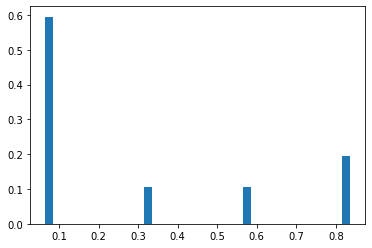

In [20]:
plt.bar(m[:,2],prob[:,2], width=0.02)

In [264]:
for k in range(inv):
    print('média', np.round(m[~np.isnan(m[:,k]),k].mean(),2), 'desvpad', np.round(m[~np.isnan(m[:,k]),k].std(),2), 'amostras', np.sum(~np.isnan(m[:,k])))


média 0.3 desvpad 0.0 amostras 1
média 0.43 desvpad 0.26 amostras 2
média 0.5 desvpad 0.28 amostras 4
média 0.54 desvpad 0.29 amostras 8
média 0.57 desvpad 0.29 amostras 16
média 0.61 desvpad 0.28 amostras 32


In [265]:
def media(k):
    ex=sum(m[~np.isnan(m[:,k]),k]*prob[~np.isnan(m[:,k]),k])
    return ex

In [266]:
def dp(k):
    ex=sum(m[~np.isnan(m[:,k]),k]*prob[~np.isnan(m[:,k]),k])
    ex2=sum(np.power(m[~np.isnan(m[:,k]),k],2)*prob[~np.isnan(m[:,k]),k])
    varx= ex2 - ex**2
    dpx=np.sqrt(varx)
    return dpx

In [268]:
for k in range(inv):
    print('média', np.round(media(k),3), 'desviop', np.round(dp(k),2), 'cenários',np.sum(~np.isnan(m[:,k])))

média 0.3 desviop 0.0 cenários 1
média 0.325 desviop 0.23 cenários 2
média 0.35 desviop 0.32 cenários 4
média 0.375 desviop 0.37 cenários 8
média 0.4 desviop 0.41 cenários 16
média 0.425 desviop 0.43 cenários 32


In [236]:
~np.isnan(m[:,k])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

Text(0.5, 1.0, 'Fator de Chance - 6º investimento')

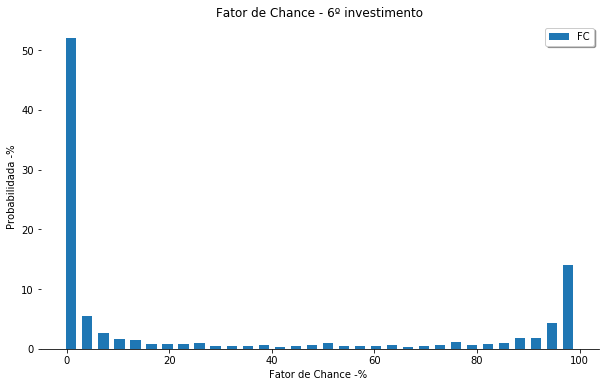

In [7]:
fig, ax= plt.subplots(1,1, figsize=(10,6))
sns.despine(left=True)

ax.bar(m[:,5]*100,prob[:,5]*100, width=2)
ax.legend(('FC', 'Fator'), loc='upper right', shadow=True)
ax.set_xlabel('Fator de Chance -% ')
ax.set_ylabel('Probabilidada -%')
ax.set_title('Fator de Chance - 6º investimento')


Text(0.5, 1.0, 'Probabilidade do FC - 4º investimento')

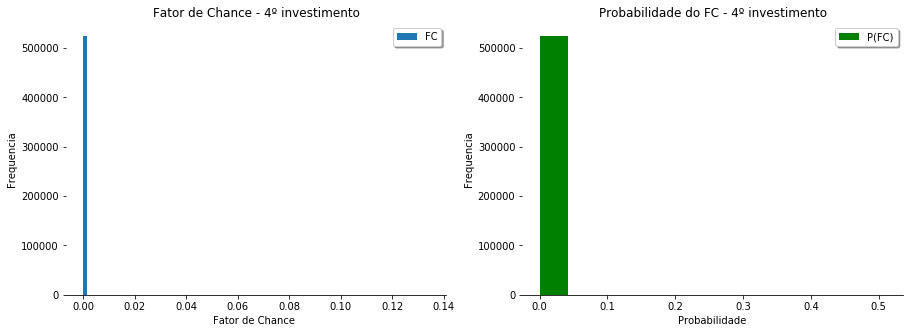

In [191]:
fig, (ax1,ax2)= plt.subplots(1,2, figsize=(15,5))
sns.despine(left=True)
n=19
#b=max(m[:,n]) - 
ax1.hist(m[:,n]*prob[:,n], bins=100)
ax1.legend(('FC', 'Fator'), loc='upper right', shadow=True)
ax1.set_xlabel('Fator de Chance ')
ax1.set_ylabel('Frequencia')
ax1.set_title('Fator de Chance - 4º investimento')

ax2.hist(prob[:,n], bins=12,color='green')
ax2.legend(('P(FC)', 'Fator'), loc='upper right', shadow=True)
ax2.set_xlabel('Probabilidade')
ax2.set_ylabel('Frequencia')
#ax1.set_xticklabels([0,1000,2000,5000,10000,50000,100000])
ax2.set_title('Probabilidade do FC - 4º investimento')

In [161]:
from matplotlib.ticker import PercentFormatter

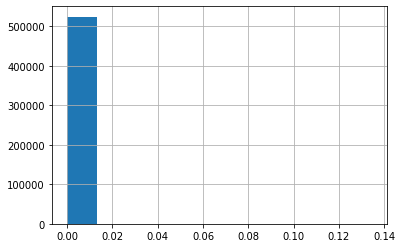

In [193]:
n=19
serie=pd.Series(m[:,n]*prob[:,n])
#serie.hist(bins=20, weights=np.ones(len(serie))/len(serie))
serie.hist()

In [194]:
serie.astype(float)

0         1.343237e-01
1         1.793418e-07
2         2.690129e-07
3         8.967161e-08
4         4.707735e-07
              ...     
524283    1.094602e-07
524284    4.378410e-07
524285    1.459465e-07
524286    2.918928e-07
524287    2.918921e-07
Length: 524288, dtype: float64

In [196]:
sum(serie>0.8)/len(serie)

0.0

In [198]:
serie.mean()

5.722045898437452e-07

In [218]:
m[~np.isnan(m[:,k]),k]*m[~np.isnan(m[:,k]),k]

array([0.77854329, 0.33913269, 0.45205587, 0.13864527, 0.54074109,
       0.18953049, 0.27599367, 0.05078307, 0.60754386, 0.22987326,
       0.32427444, 0.07260384, 0.39999427, 0.11052367, 0.17846485,
       0.01499425, 0.65662012, 0.26042752, 0.3603853 , 0.0901927 ,
       0.43999475, 0.13200215, 0.20549993, 0.02350733, 0.50044447,
       0.16599187, 0.24742765, 0.03897505, 0.3140717 , 0.0678191 ,
       0.12279488, 0.00254228])

In [21]:
\